## Import libraries

The following code comes from [this exercise](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/linear_regression_with_a_real_dataset.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=linear_regression_real_tf2-colab&hl=en) in [this section](https://developers.google.com/machine-learning/crash-course/first-steps-with-tensorflow/programming-exercises).

[This tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) was also very helpful!

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.linear_model import LinearRegression

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

device

device(type='cuda')

## Define model and helper function for analyzing results

In [4]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # or just super(LinearRegressionModel, self).__init__() for backward compatibility
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [5]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Set model to training mode
        model.train()

        # Forward pass: Compute predicted y by passing x to the model
        yhat = model(x)

        # Computes loss
        loss = loss_fn(yhat, y)

        # Computes gradients (perform backward pass)
        loss.backward()

        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [7]:
def plot_model(x, y, slope, intercept, losses):
    # Scatter plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x, y, ax=ax[0])
    ax[0].axhline(y=0, color='k', linewidth=1)  # added because i want the origin
    ax[0].axvline(x=0, color='k', linewidth=1)

    # Regression line
    x_pred = np.linspace(x.min() - 0.2, x.max() + 0.2, 50)
    y_pred = (x_pred * slope) + intercept
    sns.lineplot(x=x_pred, y=y_pred, ax=ax[0])
    
    # Loss
    epochs = np.arange(len(losses))
    sns.scatterplot(epochs, losses, ax=ax[1])
    sns.lineplot(epochs, losses, ax=ax[1])

## Linear regression with synthetic dataset

In [8]:
rng = np.random.default_rng(42)
x = rng.random(100)
y = np.sin(x) * np.power(x, 3) + 3*x + rng.random(100)*0.8

xs = torch.from_numpy(x.reshape(-1, 1)).float().to(device)
ys = torch.from_numpy(y.reshape(-1, 1)).float().to(device)

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.3
epochs = 200

# Discard any pre-existing version of the model.
my_model = None

# Define model
torch.manual_seed(42)
my_model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr = learning_rate)

losses = []
train_step = make_train_step(my_model, criterion, optimizer)
for epoch in range(epochs):
    loss = train_step(xs, ys)
    losses.append(loss)
    
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

epoch 0, loss 1.2754374742507935
epoch 10, loss 0.266264945268631
epoch 20, loss 0.16039153933525085
epoch 30, loss 0.10903462767601013
epoch 40, loss 0.08412250131368637
epoch 50, loss 0.07203816622495651
epoch 60, loss 0.06617632508277893
epoch 70, loss 0.06333289295434952
epoch 80, loss 0.0619535893201828
epoch 90, loss 0.06128451228141785
epoch 100, loss 0.06095996871590614
epoch 110, loss 0.060802534222602844
epoch 120, loss 0.06072616949677467
epoch 130, loss 0.06068912521004677
epoch 140, loss 0.06067114695906639
epoch 150, loss 0.060662440955638885
epoch 160, loss 0.060658205300569534
epoch 170, loss 0.06065615639090538
epoch 180, loss 0.06065516918897629
epoch 190, loss 0.06065468117594719


The predicted model is: y =  3.504x +  0.307
The sklearn model is: y =  3.506x +  0.307


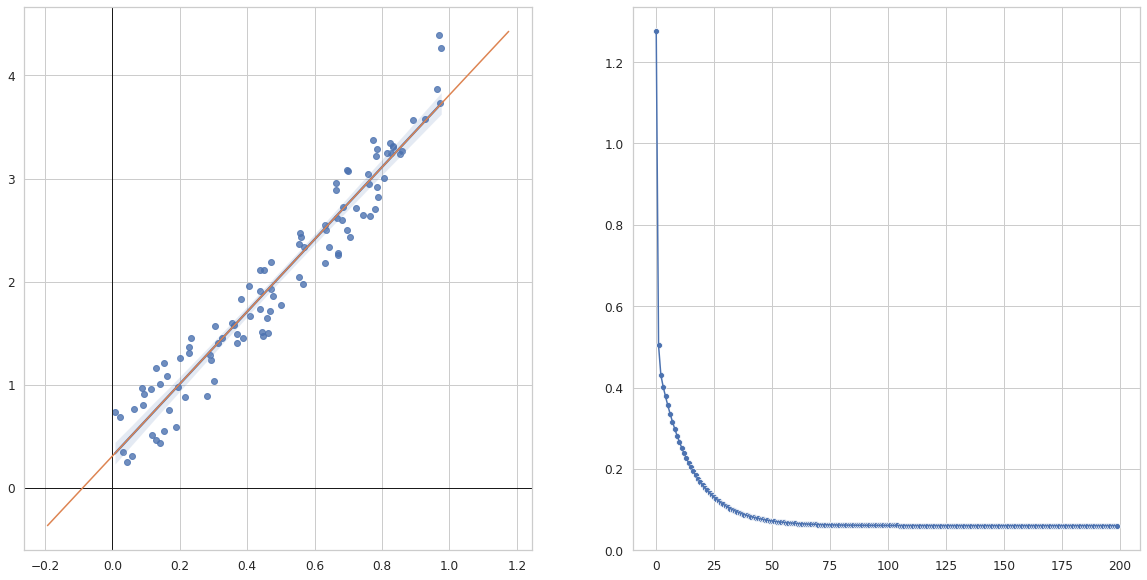

In [10]:
# Check parameters
model_beta_0 = my_model.state_dict()["linear.bias"].item()
model_beta_1 = my_model.state_dict()["linear.weight"].item()
print(f"The predicted model is: y = {model_beta_1: .3f}x + {model_beta_0: .3f}")

# Fit SLR model to check how far off we are
reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f"The sklearn model is: y = {reg.coef_[0][0]: .3f}x + {reg.intercept_[0]: .3f}")

plot_model(x, y, model_beta_1, model_beta_0, losses)

## Linear regression with real dataset

In [11]:
# Import the dataset.
df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
df["median_house_value"] /= 1000.0

### EDA

In [12]:
# Print the first rows of the pandas DataFrame.
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66.9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80.1
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85.7
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73.4
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65.5


In [13]:
# Get statistics on the dataset.
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207.300912
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115.983764
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119.400000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180.400000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


In [14]:
df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925208,-0.114250,0.047010,0.071802,0.101674,0.059628,-0.015485,-0.044982
latitude,-0.925208,1.000000,0.016454,-0.038773,-0.069373,-0.111261,-0.074902,-0.080303,-0.144917
housing_median_age,-0.114250,0.016454,1.000000,-0.360984,-0.320434,-0.295890,-0.302754,-0.115932,0.106758
total_rooms,0.047010,-0.038773,-0.360984,1.000000,0.928403,0.860170,0.919018,0.195383,0.130991
total_bedrooms,0.071802,-0.069373,-0.320434,0.928403,1.000000,0.881169,0.980920,-0.013495,0.045783
population,0.101674,-0.111261,-0.295890,0.860170,0.881169,1.000000,0.909247,-0.000638,-0.027850
households,0.059628,-0.074902,-0.302754,0.919018,0.980920,0.909247,1.000000,0.007644,0.061031
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.013495,-0.000638,0.007644,1.000000,0.691871
median_house_value,-0.044982,-0.144917,0.106758,0.130991,0.045783,-0.027850,0.061031,0.691871,1.000000


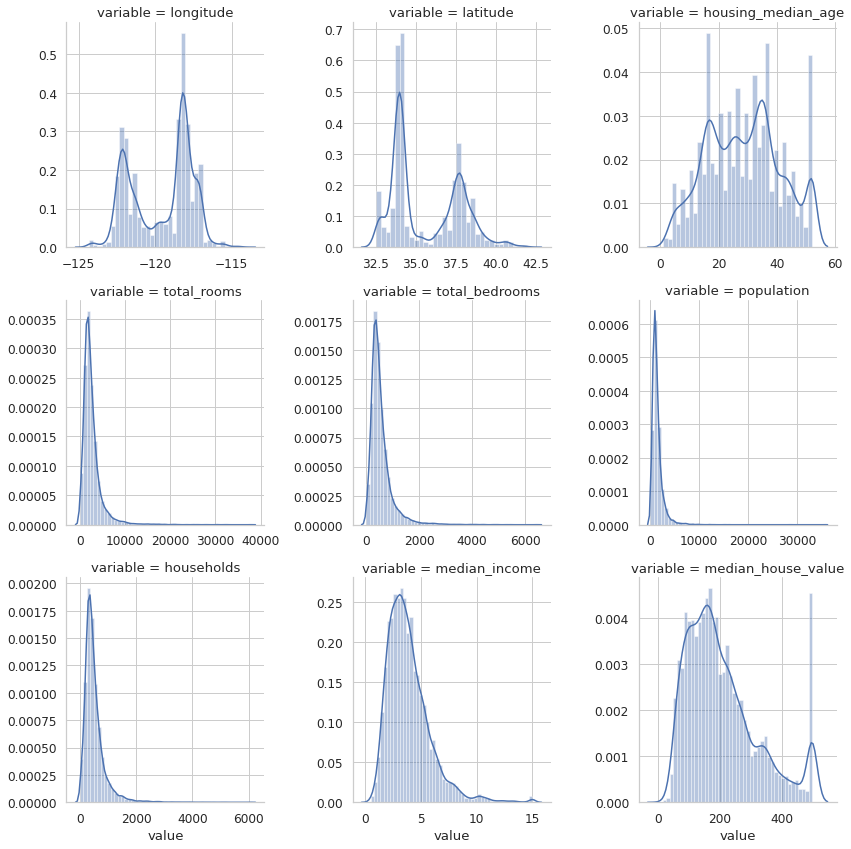

In [15]:
# Distribution of each variable (all are continuous)
g = sns.FacetGrid(df.melt(), col="variable", col_wrap=3, height=4,
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.distplot, "value")

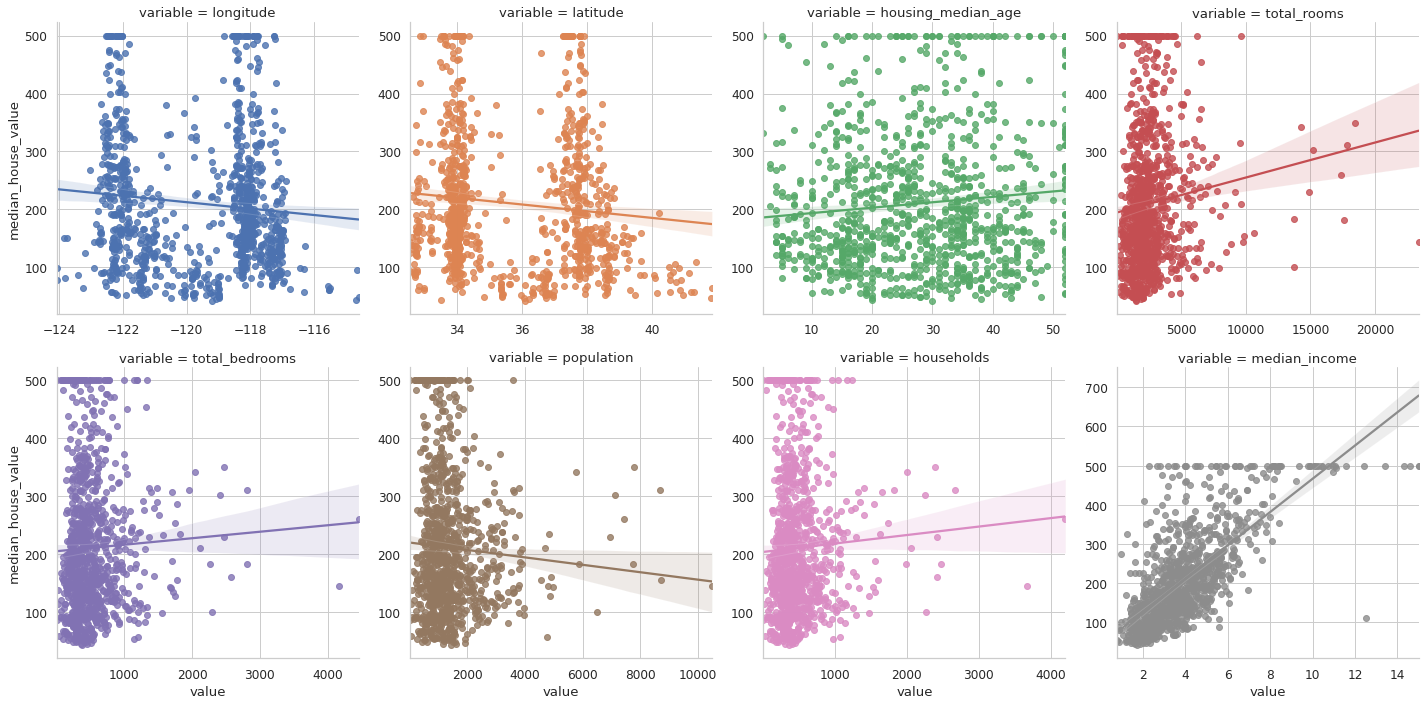

In [16]:
# Plot pairwise relationships with the label
sns.lmplot(x="value", y="median_house_value", data=df.sample(1000).melt(id_vars="median_house_value"),
           hue="variable", col="variable", col_wrap=4, sharex=False, sharey=False)

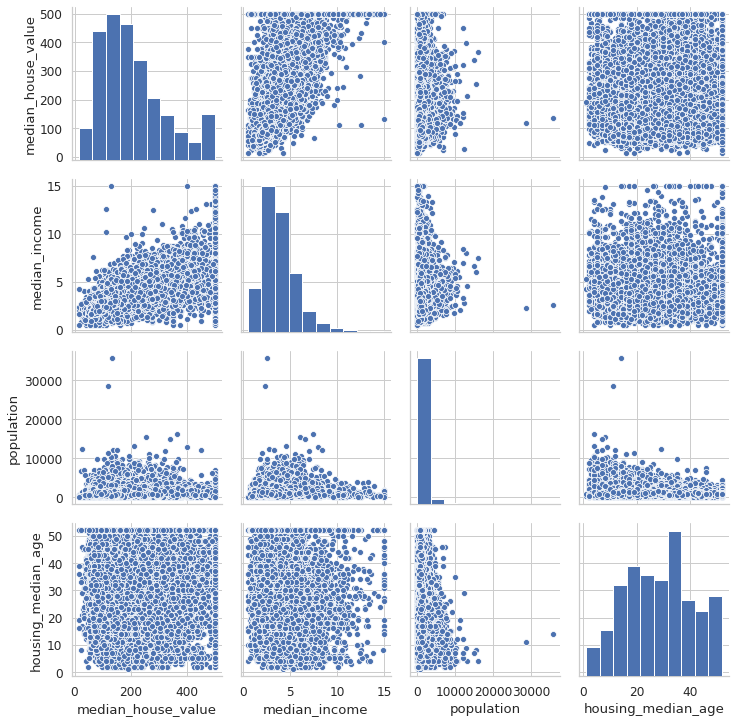

In [17]:
# Examine the likely good predictors
sns.pairplot(df, vars=["median_house_value", "median_income", "population", "housing_median_age"])

### Model training

In [18]:
# This time we create a Dataset to hold our tensors, because there's a lot
# of observations and we want to perform mini-batch gradient descent (or SGD).
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, x_col, y_col):
        self.x = torch.from_numpy(df[x_col].values.reshape(-1, 1)).float()
        self.y = torch.from_numpy(df[y_col].values.reshape(-1, 1)).float()
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [19]:
# The following variables are the hyperparameters.
learning_rate = 5e-3
epochs = 20
batch_size = 120

# Specify the feature and the label.
my_feature = "median_income"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.

In [20]:
from barbar import Bar
from IPython.display import clear_output

# Discard any pre-existing version of the model.
my_model = None

# Create Dataset to hold the training data
dat = CustomDataset(df, my_feature, my_label)
train_loader = DataLoader(dataset=dat, batch_size=batch_size, shuffle=True)

# Define the model
torch.manual_seed(42)
my_model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr = learning_rate)

# Train model
losses = []
train_step = make_train_step(my_model, criterion, optimizer)

for epoch in range(epochs):
    clear_output(wait=True)
    print(f"Epoch: {epoch + 1}")
    for idx, (x_batch, y_batch) in enumerate(Bar(train_loader)):
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)

Epoch: 20
17000/17000: [===============================>] - ETA 0.0s


The predicted model is: y =  42.335x +  43.929
The sklearn model is: y =  42.054x +  43.981


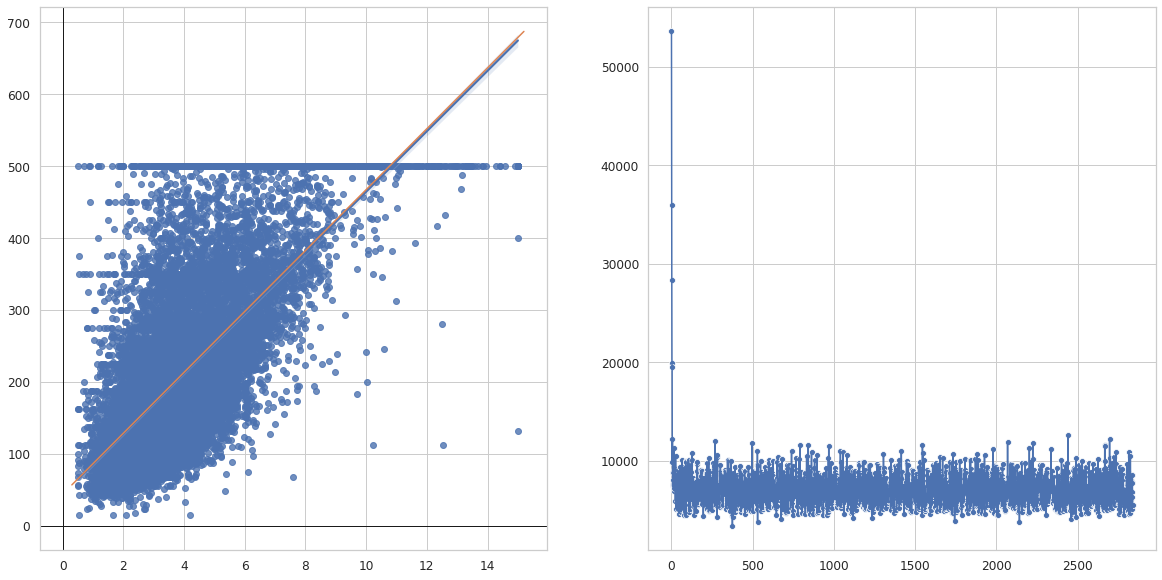

In [21]:
model_beta_0 = my_model.state_dict()["linear.bias"].item()
model_beta_1 = my_model.state_dict()["linear.weight"].item()
print(f"The predicted model is: y = {model_beta_1: .3f}x + {model_beta_0: .3f}")

# Fit SLR model to check how far off we are
x = df[my_feature].values
y = df[my_label].values
reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f"The sklearn model is: y = {reg.coef_[0][0]: .3f}x + {reg.intercept_[0]: .3f}")

plot_model(x, y, model_beta_1, model_beta_0, losses)

In [ ]:
# Predicting house prices
df_batch = df[[my_feature, my_label]].sample(10)
yhat_batch = my_model(x_batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))
    


In [44]:
df_batch = df[[my_feature, my_label]].sample(10)
df_batch["predicted_price"] = my_model(torch.from_numpy(df_batch[my_feature].values.reshape(-1, 1)).float().cuda()).cpu().detach().numpy()

df_batch

,median_income,median_house_value,predicted_price
15946,3.5114,347.500,192.585281
13373,9.3834,500.001,441.178894
14564,8.7589,434.500,414.740417
16907,2.9911,119.700,170.558151
7734,3.9615,268.600,211.640457
6091,3.5174,268.000,192.839294
15340,4.4911,227.400,234.061295
12509,1.8616,70.500,122.740295
3326,3.4150,172.500,188.504135
5790,3.5521,290.000,194.308334
